#  Entreprise OLIST

Ce notebook présente les caractéristiques de stabilité du modèle de clustering par algorythme Kmeans.

L'objectif du notebook est de représenter le comportement du clustering au fil des mois et de valider une périodicité pour la mise à jour de l'entrainement du modèle.




## Imports
Nous utiliserons les library standard de datascience : `numpy`, `pandas`, `sklearn`, `matplotlib`. 

In [1]:
import numpy as np
import pandas as pd 
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE

from yellowbrick.cluster import KElbowVisualizer, silhouette_visualizer,SilhouetteVisualizer

import folium

import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')




pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [1]:
def inspect_dupes(df, dedupe=False):
    '''
    Checks duplicates (rows), and gets rid of duplicates if dedupe arg set to 'True' 
    Arg: dataframe, dedupe (bool)
    '''
    num_of_dupe = len(df[df.duplicated()])

    if dedupe and num_of_dupe>0: 
        df.drop_duplicates(inplace=True)
        print(f'Number of duplicates found: {num_of_dupe}')
        return df

    else: 
        print(f'Number of duplicates found: {num_of_dupe}')
        return num_of_dupe
    
def iqr(df,drop=False):
   
    cols_to_keep = [col for col in df.columns if df[col].nunique() > 2]
    dataframe = df[cols_to_keep]
    
    iqr_analysis_list = []

    # Sélection des variables numériques
    numeric_variables = dataframe.select_dtypes(include=['number'])
    l_ind_outlier=[]
    
    for variable_name in numeric_variables.columns:
        # Calcul de l'analyse IQR pour chaque variable numérique
        variable_data = dataframe[variable_name]
        
        # Calcul des quartiles
        Q1 = variable_data.quantile(0.25)
        Q3 = variable_data.quantile(0.75)
        
        # Calcul de l'IQR (Interquartile Range)
        IQR = Q3 - Q1
        
        # Détermination des limites inférieure et supérieure pour détecter les valeurs aberrantes
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Exclusion des individus aberrants
        excluded_count = ((variable_data < lower_bound) | (variable_data > upper_bound)).sum()
        
        # Calcul du ratio d'exclusion
        total_count = len(variable_data)
        exclusion_ratio = excluded_count / total_count
        
        # Ajout des résultats dans une liste
        iqr_analysis_list.append({
            'Variable': variable_name,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Excluded Count': excluded_count,
            'Exclusion Ratio': exclusion_ratio
        })

        # Filtrer les valeurs en dehors des bornes IQR
        l_ind_outlier += dataframe[(dataframe[variable_name] <= lower_bound) |
                                   (dataframe[variable_name] >= upper_bound)].index.to_list()

    l_ind_outlier=set(l_ind_outlier)
    print(len(l_ind_outlier))
    
    if drop == True :
        dataframe=dataframe.drop(l_ind_outlier,axis=0)
    # Création d'un dataframe à partir de la liste des résultats
    iqr_analysis_df = pd.DataFrame(iqr_analysis_list)
    display(iqr_analysis_df.sort_values(by='Exclusion Ratio',ascending=False))
    
    return dataframe    
    
    
 # Réduit le nombre de décimale
def format_value(x):
    try:
        return f"{x:.2f}"
    except:
        return str(x)
    
  # Explorations de base du df  
def desc(df):
    print( '************************************')  
    print( '      Descriptif du dataset')
    print( '************************************')  
    print(f'Le dataset est composé de {df.shape[0]} individus et {df.shape[1]} variables.')
    display(df.head())
    display(df.dtypes)
    display(df.describe())
    display(bilan_null(df).sort_values(by='Missing ratio',ascending = True))

  # Renvoie un df avec les Nunique et des infos sur les NaN      
def bilan_null(df):
    df_bilan=pd.concat([df.nunique(),
                        df.isnull().mean(),
                        df.isnull().sum(),
                        df.notnull().sum()],
                        axis=1,
                        keys=['Nunique','Missing ratio','Null count','Notnull count'])
    return df_bilan.sort_values(by='Missing ratio')

    
def group_and_RFM(df) :
    df_gr = df.groupby('customer_unique_id', as_index=True).agg(
    COUNT_sale=('order_purchase_timestamp', 'count'),
    SUM_price=('price', 'sum'),
    last_sale=('diff', 'min'),
    AVG_review_score=('review_score', 'mean')
    )
    df_gr = df_gr[['last_sale', 'COUNT_sale', 'SUM_price', 'AVG_review_score']]
    df_gr['R_score'] = pd.cut(df_gr['last_sale'],
                                   bins=[-0.001, 142.0, 227.0, 317.0, 433.0, np.inf],
                                   labels=[5, 4, 3, 2, 1])
    df_gr['F_score'] = pd.cut(df_gr['COUNT_sale'],
                                   bins=[0.5, 1.5, 2.5, np.inf],
                                   labels=[1, 3, 5])
    df_gr['M_score'] = pd.cut(df_gr['SUM_price'],
                                   bins=[-0.001, 39.0, 69.0, 109.9, 179.9, np.inf],
                                   labels=[1, 2, 3, 4, 5])
    df_gr['H_score'] = pd.cut(df_gr['AVG_review_score'],
                                   bins=[-0.001, 1.8, 2.6, 3.4, 4.2, 5.1],
                                   labels=[1, 2, 3, 4, 5])

    df_gr = df_gr[['R_score', 'F_score', 'M_score', 'H_score']]
    return df_gr

##  Chargement des données

df_o = orders_202405281111.csv  
df_i = order_items_202405281111.csv  
df_c = customers_202405281111.csv  
df_r = order_reviews_202405281111.csv  
df_g = extract_groupby.csv  => Résultat de l'aggrégation de feature après l'extraction avec jointure

Requete SQL
> SELECT customer_unique_id,
       COUNT(order_purchase_timestamp) AS COUNT_sale,   
       AVG(review_score) AS AVG_review_score,  
       AVG(price) AS AVG_price,  
       MIN(price) AS MIN_price,  
       MAX(price) AS MAX_price,  
       SUM(price) AS SUM_price,  
       JULIANDAY(DATE('2018-10-17 17:30:18') ) - JULIANDAY(MIN(DATE(order_purchase_timestamp) ) ) AS first_sale,  
       JULIANDAY(DATE('2018-10-17 17:30:18') ) - JULIANDAY(MAX(DATE(order_purchase_timestamp) ) ) AS last_sale,  
       customer_state,  
       review_comment_message,  
       order_status  
  FROM orders o  
       LEFT JOIN  
       customers c ON o.customer_id = c.customer_id  
       LEFT JOIN  
       order_reviews re ON o.order_id = re.order_id  
       LEFT JOIN  
       order_items oi ON o.order_id = oi.order_id  
 GROUP BY customer_unique_id  


Commençons par visualiser 'application_train.csv' : 

In [3]:
# Training data
df_o = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\data\\orders_202405281111.csv')
df_i = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\data\\order_items_202405281111.csv')
df_c = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\data\\customers_202405281111.csv')
df_r = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\data\\order_reviews_202405281111.csv')
df_g = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\5.Olist\\extract_groupby.csv')

In [4]:
df_o.groupby('order_status').count()

,index,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_status,,,,,,,,
approved,2,2,2,2,2,0,0,2
canceled,625,625,625,625,484,75,6,625
created,5,5,5,5,0,0,0,5
delivered,96478,96478,96478,96478,96464,96476,96470,96478
invoiced,314,314,314,314,314,0,0,314
processing,301,301,301,301,301,0,0,301
shipped,1107,1107,1107,1107,1107,1107,0,1107
unavailable,609,609,609,609,609,0,0,609


In [5]:
df_o.drop('index',axis=1,inplace=True)

In [6]:
df_merged1 =       df_o.merge(df_c, on= 'customer_id', how='left')
df_merged2 = df_merged1.merge(df_r, on= 'order_id', how='left')
df_merged3 = df_merged2.merge(df_i, on= 'order_id', how='left')

In [7]:
bilan_null(df_merged1)
bilan_null(df_merged2)
bilan_null(df_merged3)

,Nunique,Missing ratio,Null count,Notnull count
order_id,99441,0.000000,0,114092
customer_id,99441,0.000000,0,114092
order_status,8,0.000000,0,114092
order_purchase_timestamp,98875,0.000000,0,114092
order_estimated_delivery_date,459,0.000000,0,114092
index_x,99441,0.000000,0,114092
customer_unique_id,96096,0.000000,0,114092
customer_zip_code_prefix,14994,0.000000,0,114092
customer_city,4119,0.000000,0,114092
customer_state,27,0.000000,0,114092


In [8]:
df_merged3['order_purchase_timestamp'] =  pd.to_datetime(df_merged3['order_purchase_timestamp']) 
df_merged3['diff'] =pd.to_datetime('2018-10-17 17:30:18') - df_merged3['order_purchase_timestamp'] 
df_merged3['diff']=df_merged3['diff'].map(lambda x : x.days)

df3_gr = df_merged3.groupby('customer_unique_id', as_index=False, dropna=False).agg( 
    COUNT_sale=('order_purchase_timestamp', 'count'),
    SUM_price=('price', 'sum'),
    last_sale=('diff', 'min'),
    AVG_review_score=('review_score', 'mean')
)

df3_gr['AVG_review_score'].fillna(df3_gr['AVG_review_score'].median(), inplace=True)
df3_gr.fillna(0, inplace=True)



Faisons un point d'arrêt pour vérifier que nos données fusionnées cette fois-ci en python (df3_gr) correspondent bien à l'extract réalisé en SQL lors de la partie précédente (df_g) 

In [9]:
df3_gr.describe()

,COUNT_sale,SUM_price,last_sale,AVG_review_score
count,96096.000000,96096.000000,96096.000000,96096.000000
mean,1.187271,142.065471,287.735691,4.091513
std,0.650974,218.435272,153.414676,1.339311
min,1.000000,0.000000,0.000000,1.000000
25%,1.000000,46.000000,163.000000,4.000000
50%,1.000000,89.000000,268.000000,5.000000
75%,1.000000,154.990000,397.000000,5.000000
max,24.000000,13440.000000,772.000000,5.000000


In [10]:
df_g = df_g[['COUNT_sale','SUM_price','last_sale','AVG_review_score']]
df_g['AVG_review_score'].fillna(df_g['AVG_review_score'].median(), inplace=True)
df_g.fillna(0, inplace=True)

df_g.describe()

,COUNT_sale,SUM_price,last_sale,AVG_review_score
count,96096.000000,96096.000000,96096.000000,96096.000000
mean,1.187271,142.065471,288.108797,4.091513
std,0.650974,218.435272,153.417869,1.339311
min,1.000000,0.000000,0.000000,1.000000
25%,1.000000,46.000000,164.000000,4.000000
50%,1.000000,89.000000,269.000000,5.000000
75%,1.000000,154.990000,397.000000,5.000000
max,24.000000,13440.000000,773.000000,5.000000


Les données correspondent, le merge s'est bien passé.

Nous pouvons revenir à notre préparation de données en constituant une liste de dataframe distribuée sur une fréquence de 2 mois :

In [46]:
# sample data
df = df_merged3
df['review_score'].fillna(df['review_score'].median(), inplace=True)
df.fillna(0, inplace=True)
# groupby your key and freq
g = df.groupby(pd.Grouper(key='order_purchase_timestamp', freq='3M'))
# groups to a list of dataframes with list comprehension
dfs = [group for _,group in g]

for df in dfs :
    display(df.head(3))

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_y,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff
5143,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,0,2016-10-20 00:00:00,84697,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,74443.0,cef1ee03ded4d6272894a2eead6e1328,1.0,0,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22 00:00:00,2016-11-15 16:00:34,20265.0,1.0,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,772
5144,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,0,2016-10-20 00:00:00,84697,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,74443.0,cef1ee03ded4d6272894a2eead6e1328,1.0,0,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22 00:00:00,2016-11-15 16:00:34,20266.0,2.0,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,772
4982,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,0,0,2016-10-28 00:00:00,70561,4854e9b3feff728c13ee5fc7d1547e92,99025,passo fundo,RS,30479.0,a93139d9d1314158c080e3db7e79618b,1.0,0,Comprei dois produtos desta loja parceira da l...,2016-10-29 00:00:00,2016-10-30 01:47:48,101394.0,1.0,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,2016-09-19 00:15:34,59.50,15.56,772


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_y,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff
95193,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02 22:07:52,2016-10-06 15:50:56,0,0,2016-10-25 00:00:00,90294,0eb1ee9dba87f5b36b4613a65074337c,2975,sao paulo,SP,39707.0,34d62feeefaf60ef6ff7204af19fe109,1.0,0,0,2016-10-27 00:00:00,2016-10-27 23:40:51,49808.0,1.0,d2998d7ced12f83f9b832f33cf6507b6,25e6ffe976bd75618accfe16cefcbd0d,2016-10-21 16:19:54,100.0,9.34,744
106971,3b697a20d9e427646d92567910af6d57,355077684019f7f60a031656bd7262b8,delivered,2016-10-03 09:44:50,2016-10-06 15:50:54,2016-10-23 14:02:13,2016-10-26 14:02:13,2016-10-27 00:00:00,38634,32ea3bdedab835c3aa6cb68ce66565ef,4106,sao paulo,SP,49851.0,9fe0f66724df77fd63fcc0c94a323978,4.0,0,Facilidade em manusear o aparelho.,2016-10-26 00:00:00,2016-10-30 21:32:15,26119.0,1.0,3ae08df6bcbfe23586dd431c40bddbb7,522620dcb18a6b31cd7bdf73665113a9,2016-10-21 16:27:20,29.9,15.56,744
32579,be5bc2f0da14d8071e2d45451ad119d9,7ec40b22510fdbea1b08921dd39e63d8,delivered,2016-10-03 16:56:50,2016-10-06 16:03:44,2016-10-21 16:33:46,2016-10-27 18:19:38,2016-11-07 00:00:00,55191,2f64e403852e6893ae37485d5fcacdaf,98280,panambi,RS,98370.0,dc62f1e20d7f280e54066b6a92841086,4.0,0,Tudo certo...,2016-10-28 00:00:00,2016-10-29 11:29:53,83810.0,1.0,fd7fd78fd3cbc1b0a6370a7909c0a629,f09b760d23495ac9a7e00d29b769007c,2016-10-21 16:33:46,21.9,17.19,744


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_y,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff
90247,ec7a019261fce44180373d45b442d78f,c24fc5f9a446b4d8262041b9c64de772,delivered,2017-01-05 11:56:06,2017-01-05 12:10:17,2017-01-06 12:43:41,2017-01-11 13:14:05,2017-02-01 00:00:00,18994,f7b981e8a280e455ac3cbe0d5d171bd1,80030,curitiba,PR,41219.0,5f45d6aa32336fa26cbc254721c81880,5.0,0,Adorei o produto! Super recomendo o lojista. R...,2017-01-12 00:00:00,2017-01-13 20:22:46,104115.0,1.0,f5d8f4fbc70ca2a0038b9a0010ed5cb0,48efc9d94a9834137efd9ea76b065a38,2017-01-09 11:56:06,10.9,8.72,650
18516,b95a0a8bd30aece4e94e81f0591249d8,ff3c6d35b4927c9b965aa6a68dcf56e4,delivered,2017-01-05 12:01:20,2017-01-07 03:35:37,2017-01-11 16:22:53,2017-01-17 15:38:58,2017-02-13 00:00:00,49074,83e7958a94bd7f74a9414d8782f87628,80030,curitiba,PR,54691.0,4e9bc73d2795d85dc2e8b7dbb99e304c,5.0,0,"Adorei o produto, condiz com as imagens, a ent...",2017-01-18 00:00:00,2017-01-18 10:56:46,81567.0,1.0,6c04a068e5ab37749c980c42a036b9e3,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:01:20,10.9,8.72,650
85580,38bcb524e1c38c2c1b60600a80fc8999,d2c63ad286e3ca9dd69218008d61ff81,delivered,2017-01-05 12:06:36,2017-01-07 03:45:22,2017-01-11 15:35:54,2017-01-16 16:05:22,2017-02-13 00:00:00,44238,728e4a7d0db4845270091ded0923c71f,80540,curitiba,PR,91442.0,e48def6468ee7a31da5dc7249487304c,5.0,0,Loja entregou no prazo sem qualquer problema. ...,2017-01-17 00:00:00,2017-01-18 11:51:43,24916.0,1.0,680cc8535be7cc69544238c1d6a83fe8,48efc9d94a9834137efd9ea76b065a38,2017-01-09 12:06:36,2.9,8.72,650


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_y,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff
98094,9d343b43e2a3552fdfaff5ad21a9af61,a0c5cbf7dae5ccd736f5c2576bccf564,delivered,2017-04-01 00:54:10,2017-04-01 01:05:30,2017-04-05 06:50:07,2017-04-17 17:36:58,2017-04-26 00:00:00,11534,c6c431ac2e6fb4433711fa86143dc446,30431,belo horizonte,MG,30856.0,6004fe92d0b8c784067bde75d0ae5bc0,5.0,0,Recomendo o stark e parceiros,2017-04-18 00:00:00,2017-04-19 18:41:32,68809.0,1.0,5e2ba75ad255ff60b1c76c5bf526ae9b,f84a00e60c73a49e7e851c9bdca3a5bb,2017-04-06 01:05:30,69.90,14.25,564
56933,e49d81cefb427df79734efdb90023352,9133fb73714e995e2a4426ea1753c3fd,delivered,2017-04-01 00:55:07,2017-04-01 01:05:24,2017-04-05 12:50:19,2017-04-10 06:30:04,2017-05-09 00:00:00,92167,df2c418b45e7990646635bb042cb1dba,4505,sao paulo,SP,7713.0,ceb886db5c5635f41a3137408e30a015,5.0,0,0,2017-04-11 00:00:00,2017-04-11 17:17:59,100829.0,1.0,3f90ef42e637c17203bd0ee040c16de0,d2374cbcbb3ca4ab1086534108cc3ab7,2017-04-20 01:05:24,25.90,10.96,564
77894,fed4ca34aeb50d89ab8f08db03c8c800,2c51d0c600a3cf399f2afad8a74ae1b1,delivered,2017-04-01 02:05:23,2017-04-01 02:22:30,2017-04-07 13:34:52,2017-04-11 09:55:01,2017-05-16 00:00:00,79741,b99d74a79c10e715adaf03cd5779b787,17012,bauru,SP,66151.0,d2afa617412f0feaae8c6acb8d94db29,5.0,0,0,2017-04-12 00:00:00,2017-04-17 14:46:10,112162.0,1.0,3e591cbf1cec40074c24a2ce372a5b62,3faf68a3b0af94b10bac70d86077be49,2017-04-28 02:22:30,188.99,15.09,564


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_y,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff
85985,0560d129c1357ea719aab1cf2cd4f03b,31fbacf0ea2089c524643a24907ff72f,delivered,2017-07-01 00:04:15,2017-07-01 00:15:36,2017-07-04 14:12:40,2017-07-06 18:25:36,2017-07-14 00:00:00,56131,bc1b8aa17fbc6b2ebd22711951614b02,9420,ribeirao pires,SP,49343.0,c6a8ebde2122565bca89ff7d32b58c9e,1.0,0,"Está constando que a mercadoria foi entrega, p...",2017-07-07 00:00:00,2017-07-09 21:07:10,2386.0,1.0,65650c84064ff1a79e4a05988f4c3e9f,aced59e9b31ef866a94f9e7f29d8d418,2017-07-06 00:15:36,35.00,9.34,473
28791,cec9f2d01230a5ec8b92b222bdcb3c41,1fbd8147176eca1835aa64b2f0e5e32f,delivered,2017-07-01 00:15:30,2017-07-01 14:43:45,2017-07-07 18:23:14,2017-07-17 20:33:40,2017-08-02 00:00:00,16020,ece666ce869d4ab864a296b4f279525e,89460,canoinhas,SC,40553.0,1db42d34c60c8a434e19ceef80461128,3.0,0,faltou uma peca na cadeira,2017-07-18 00:00:00,2017-07-19 22:33:10,91064.0,1.0,967a628ee966c8a0a167ed5efaba52a0,7c67e1448b00f6e969d365cea6b010ab,2017-07-14 14:43:45,279.99,74.91,473
39274,a42b8e89c40b20239fd256bd449eb7b7,f62a748374fb9339c8b2a648c160715b,delivered,2017-07-01 00:17:33,2017-07-01 00:25:13,2017-07-04 15:37:34,2017-07-10 18:53:37,2017-07-25 00:00:00,10629,e46a2eeb7d8cd4dc8e79b4cbf6354fc0,36080,juiz de fora,MG,97224.0,e55248d8eac7834096a2117f381ed03b,4.0,0,0,2017-07-11 00:00:00,2017-07-13 23:28:20,71959.0,1.0,21a95b5525c6d658ff4e5e1b50f7c02d,46dc3b2cc0980fb8ec44634e21d2718e,2017-07-06 00:25:13,129.99,13.79,473


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_y,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff
56770,80c86e92eef37052119cf0e9a402000a,4f0e61854cebd81bf24298cea5d99a7d,delivered,2017-10-01 00:03:33,2017-10-03 04:04:38,2017-10-04 12:14:37,2017-10-06 18:26:36,2017-10-18 00:00:00,69939,b7cff635b3789bb1c7f1c4c0f4cda419,13283,vinhedo,SP,85131.0,e49ca04a3ef3760cf1feae22691f40ad,5.0,0,0,2017-10-07 00:00:00,2017-10-09 22:02:14,56619.0,1.0,f908d3bf313a1308bfb2a46ea2685347,25e6ffe976bd75618accfe16cefcbd0d,2017-10-09 04:04:38,35.00,7.78,381
34102,f9a6e72c6b5a49a9aaa0a85b32adc581,3f6fd186f7e40f9cd5a3c8c3965b7c48,delivered,2017-10-01 00:06:09,2017-10-01 00:28:20,2017-10-02 19:52:18,2017-10-13 19:44:08,2017-10-31 00:00:00,72923,c822278f481496d96d7e830d49d64b65,80050,curitiba,PR,93532.0,5c84fdd098adc734429642a1464b0a99,5.0,0,O produto foi entregue bem antes do prazo e é ...,2017-10-14 00:00:00,2017-10-14 16:15:28,109859.0,1.0,71da6d6632902431cdca2b3a8e681b80,3078096983cf766a32a06257648502d1,2017-10-05 00:28:20,184.60,18.54,381
14810,aefefdda7b7a272ca35c44b82b643104,fd129ee6af6e2c7043f8029e814a7ad9,delivered,2017-10-01 00:15:12,2017-10-03 04:05:06,2017-10-04 10:18:15,2017-10-09 17:48:09,2017-11-01 00:00:00,45241,6349ef91b6fd64652c8dab6fda20c2ee,65048,sao luis,MA,49552.0,8c8299108c3c1594932dd60e0f034ee3,4.0,0,Foi muito rápido e eficiente .... obrigado,2017-10-10 00:00:00,2017-10-12 21:41:32,76874.0,1.0,f177b434709ecb652dbee4f4b19aef2f,d98eec89afa3380e14463da2aabaea72,2017-10-09 04:05:06,29.99,31.02,381


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_y,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff
106892,4f6daad34df49e10c8072b33faafcb2a,73eb345e2b03af4125d07ca4a250d06a,delivered,2018-01-01 02:48:41,2018-01-01 02:58:25,2018-01-05 18:36:58,2018-01-30 18:43:20,2018-02-05 00:00:00,38683,1014f90d8a2b105b55da659d50f73625,57015,maceio,AL,70803.0,897a69d87dd03229792971dc265bce68,5.0,0,Não testei ainda o equipamento.,2018-01-31 00:00:00,2018-01-31 22:13:08,35073.0,1.0,468a4d241243dd96169888c0ad022086,e067ad2c1c0b48758eb1b5228bcf7a68,2018-01-05 02:58:25,148.0,36.36,289
82257,0462bad26ccfb8508951beb9ea398ae1,b1449a43a666cba48f485fff0a509b8e,delivered,2018-01-01 08:37:46,2018-01-01 08:48:19,2018-01-02 17:42:48,2018-01-23 18:15:19,2018-02-09 00:00:00,15274,9443ba3216ed3d0c97bc6f688b181e3b,29600,afonso claudio,ES,22706.0,d44741a860604f5b10b91f2ca4bb3c8a,5.0,0,0,2018-01-24 00:00:00,2018-01-24 22:00:51,1935.0,1.0,d93d7e81a8d724c4ef661e75647cf325,5a93f3ab0ef4c84ed5e1b5dbf23978bc,2018-01-15 08:48:19,151.2,18.31,289
14318,fbe41a4974e4a492e085d90e5be0b3e3,3afe7d56a3df6e202fc6b851b1cfce3b,delivered,2018-01-01 08:45:04,2018-01-01 08:55:31,2018-01-02 22:33:59,2018-01-05 14:18:41,2018-01-29 00:00:00,35875,0b204f7a8ce8a7b5575b7e5861e3d3ef,12215,sao jose dos campos,SP,70188.0,e2538b3a4a2529486c9525452fea61aa,5.0,0,0,2018-01-06 00:00:00,2018-01-06 18:45:42,110864.0,1.0,a096400f2b6fbe9c868f7dd5f1333e5a,cbd996ad3c1b7dc71fd0e5f5df9087e2,2018-01-09 08:55:31,43.2,11.85,289


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_y,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff
42895,705402bc1d956067338873d414158d09,35a436968e81c497c7f713bac80c42d0,delivered,2018-04-01 00:11:32,2018-04-01 00:31:21,2018-04-03 19:22:47,2018-04-30 16:12:13,2018-04-20 00:00:00,65526,989d76487f04e6534d02ef3fb5ed0863,24210,niteroi,RJ,106.0,d23ac17822a812782cf7f848b2a8b38b,1.0,0,0,2018-04-22 00:00:00,2018-04-26 10:25:11,49423.0,1.0,13b65def7883556df481f81caf3908c2,1835b56ce799e6a4dc4eddc053f04066,2018-04-05 00:30:03,149.90,18.93,199
69435,b1a7bd6a9d10076c91e88bc510406b46,042b53f9e609289d8f6fcbd59b4acf63,delivered,2018-04-01 00:27:33,2018-04-02 00:30:00,2018-04-14 00:06:28,2018-04-26 13:04:13,2018-05-07 00:00:00,79253,f722ff3c670cc731721553596b8de3a8,24451,sao goncalo,RJ,79573.0,c2d743e9cdfb74a2a007091fc658238e,2.0,ressarcimento taxa de ent,BOM DIA VENHO INFORMAR QUE O PRODUTO NÃO FOI E...,2018-04-27 00:00:00,2018-05-07 14:16:40,78076.0,1.0,3bf87d2001b8176e6a3ad804b80774b4,7c67e1448b00f6e969d365cea6b010ab,2018-04-16 00:30:00,192.99,64.67,199
69436,b1a7bd6a9d10076c91e88bc510406b46,042b53f9e609289d8f6fcbd59b4acf63,delivered,2018-04-01 00:27:33,2018-04-02 00:30:00,2018-04-14 00:06:28,2018-04-26 13:04:13,2018-05-07 00:00:00,79253,f722ff3c670cc731721553596b8de3a8,24451,sao goncalo,RJ,79573.0,c2d743e9cdfb74a2a007091fc658238e,2.0,ressarcimento taxa de ent,BOM DIA VENHO INFORMAR QUE O PRODUTO NÃO FOI E...,2018-04-27 00:00:00,2018-05-07 14:16:40,78077.0,2.0,30de9bc2bc110c6a584cacba9c17d88a,7c67e1448b00f6e969d365cea6b010ab,2018-04-16 00:30:00,192.99,64.67,199


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_y,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff
24798,9d6a4798ca60c057f632bed582e5b0c5,ab1a8af7afb01624d04f78edb04a5d39,delivered,2018-07-01 00:25:07,2018-07-01 00:48:32,2018-07-02 19:05:00,2018-07-03 21:06:53,2018-07-19 00:00:00,44771,16e1cfa8f090f7b765fb08945e38e9d6,11045,santos,SP,76895.0,a7fde411129aa9ea56d984b5c77da869,5.0,Compra Ok,"Tudo certo, entrega rápida!",2018-07-04 00:00:00,2018-07-05 02:24:21,68921.0,1.0,abe0406750c920638274baad5a52d61e,7dc8c42cc750eeafea6c85712ffee9bf,2018-07-05 00:48:32,9.99,8.88,108
58811,3a05c5202070d944a10db60144ddf04b,78ee827873e4946a08fd80efaf75140d,delivered,2018-07-01 00:25:23,2018-07-01 00:48:31,2018-07-02 11:57:00,2018-07-06 17:51:58,2018-07-25 00:00:00,7690,518614d35d240f297c3e88ae861f08e5,5410,sao paulo,SP,64082.0,7bb44451dc781611da1ff1926f1e657f,5.0,0,0,2018-07-07 00:00:00,2018-07-10 01:02:44,25512.0,1.0,180fbb426ea5ab0708d43ad3f3839bb9,8b9d6eec4a7eb7d0f9d579ce0b38324d,2018-07-03 00:48:31,99.00,33.17,108
29849,37c647851a4d30342bc4dd9ec8c95861,e8a26c14acdc374e3333cb0877a04558,delivered,2018-07-01 00:49:58,2018-07-02 00:49:57,2018-07-03 15:50:00,2018-07-11 21:56:35,2018-08-06 00:00:00,72679,4fc947b98e39aa4adf055a99dd82fe13,22081,rio de janeiro,RJ,33815.0,b338d71362b0befeea1fea45df5b0c55,1.0,Não recebi retorno,"Estou aguardando uma luminária que não chegou,...",2018-07-12 00:00:00,2018-07-16 13:06:07,24477.0,1.0,b0961721fd839e9982420e807758a2a6,1f50f920176fa81dab994f9023523100,2018-07-04 00:49:57,49.90,41.33,108


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,index_y,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,index,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,diff
101413,616fa7d4871b87832197b2a137a115d2,bf6181a85bbb4115736c0a8db1a53be3,canceled,2018-10-01 15:30:09,0,0,0,2018-10-23 00:00:00,75902,634420a0ea42302205032ed44ac7fccc,27175,pirai,RJ,37168.0,8b8f495d30fca09fdc8312e96de1bc47,2.0,0,0,2018-08-23 00:00:00,2018-08-23 23:14:33,0.0,0.0,0,0,0,0.0,0.0,16
36573,a2ac6dad85cf8af5b0afb510a240fe8c,4c2ec60c29d10c34bd49cb88aa85cfc4,canceled,2018-10-03 18:55:29,0,0,0,2018-10-16 00:00:00,68312,af5454198a97379394cacf676e1e96cb,11900,registro,SP,92768.0,4548534449b1f572e357211b90724f1b,1.0,0,quero devolver o produto comprei um veio outro...,2018-08-18 00:00:00,2018-08-19 00:39:54,0.0,0.0,0,0,0,0.0,0.0,13
78372,b059ee4de278302d550a3035c4cdb740,856336203359aa6a61bf3826f7d84c49,canceled,2018-10-16 20:16:02,0,0,0,2018-11-12 00:00:00,69139,262e1f1e26e92e86375f86840b4ffd63,64600,picos,PI,92235.0,48198628b2d43ed394089750acc59c3f,5.0,Gostei,Os produtos são de boa qualidade e o preço que...,2018-06-27 00:00:00,2018-06-30 01:48:53,0.0,0.0,0,0,0,0.0,0.0,0


Period from 2016-09-04 21:15:19 to 2016-09-15 12:16:38
Total sale :  7
 --------------------------- 
Period from 2016-10-02 22:07:52 to 2016-12-23 23:16:47
Total sale :  384
 --------------------------- 
Period from 2017-01-05 11:56:06 to 2017-03-31 23:54:45
Total sale :  6047
 --------------------------- 
Period from 2017-04-01 00:54:10 to 2017-06-30 23:20:08
Total sale :  10575
 --------------------------- 
Period from 2017-07-01 00:04:15 to 2017-09-30 23:59:15
Total sale :  14532
 --------------------------- 
Period from 2017-10-01 00:03:33 to 2017-12-31 23:29:31
Total sale :  20639
 --------------------------- 
Period from 2018-01-01 02:48:41 to 2018-03-31 23:54:10
Total sale :  24407
 --------------------------- 
Period from 2018-04-01 00:11:32 to 2018-06-30 23:59:49
Total sale :  23037
 --------------------------- 
Period from 2018-07-01 00:25:07 to 2018-09-29 09:13:03
Total sale :  14460
 --------------------------- 
Period from 2018-10-01 15:30:09 to 2018-10-17 17:30:18
Total s

<Axes: >

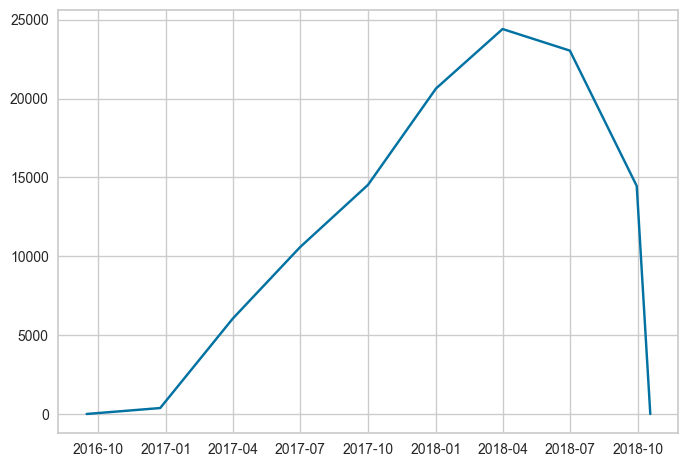

In [47]:
L_vente = []
L_date = []

for df_period in dfs :
    print(f'Period from {df_period['order_purchase_timestamp'].min()} to {df_period['order_purchase_timestamp'].max()}')
    print('Total sale : ', df_period['order_purchase_timestamp'].count())
    print(' --------------------------- ')
    L_vente.append(df_period['order_purchase_timestamp'].count())
    L_date.append(df_period['order_purchase_timestamp'].max())
    

sns.lineplot(x=L_date,y=L_vente,)

Le début d'année 2016 et la fin d'année 2018 présentent nettement moins de commandes que le reste de l'année.   


### Méthodologie 

Dans la suite du notebook, nous allons simuler le comportement du clustering au fil du temps. 

Nous allons procéder en 4 étapes :

* 1 Définition d'une valeur initiale des clusters sur les 2 premiers mois
* 2 Ajout progressif de nouvelles données tous les deux mois
* 3 Évaluation du clustering par la métrique adjusted_rand_score, comparaison de la prédiction entrainée sur n-2 par rapport a la prédiction entrainée sur n
* 4 Définition de la périodicité de la maintenance





-------------------------------------------------------------------------
 Period from 2017-04-01     to 2017-06-30
-------------------------------------------------------------------------



-------------------------------------------------------------------------
 Period from 2017-07-01     to 2017-09-30
-------------------------------------------------------------------------



-------------------------------------------------------------------------
 Period from 2017-10-01     to 2017-12-31
-------------------------------------------------------------------------



-------------------------------------------------------------------------
 Period from 2018-01-01     to 2018-03-31
-------------------------------------------------------------------------



-------------------------------------------------------------------------
 Period from 2018-04-01     to 2018-06-30
-------------------------------------------------------------------------


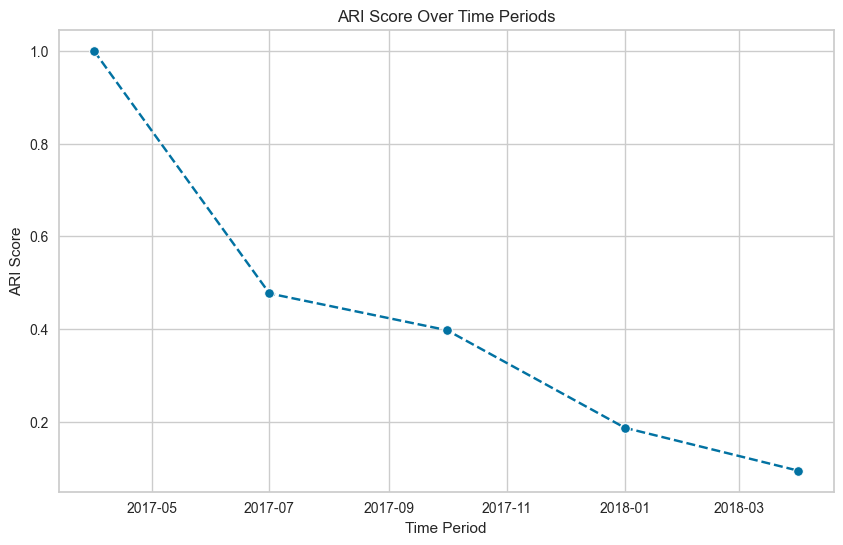

In [49]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

# Placeholder to store ARI scores
ari_scores = []
periods =[]


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=5, random_state=42))
])


dfs_eval = dfs[n_init:-1]


# Iterate over time periods
for n,df_m in enumerate(dfs_eval[:-1]) :
    print('\n\n\n-------------------------------------------------------------------------')
    print(f''' Period from {df_m["order_purchase_timestamp"].min().date()}     to {df_m["order_purchase_timestamp"].max().date()}''')
    print('-------------------------------------------------------------------------')
   
    df_curr_gr = group_and_RFM(df_m)

    if n == 0 : 
        df_prev_gr = df_curr_gr
    else :
        df_prev_gr = group_and_RFM(dfs_eval[n-1])
        
    model_curr = pipeline.fit(df_curr_gr)
    y_curr = pipeline.fit_predict(df_curr_gr)
    
    model_prev = pipeline.fit(df_prev_gr)
    y_prev = model_prev.predict(df_curr_gr)    
    # Calculate ARI between the previous period's true labels and the current period's clusters
    ari = adjusted_rand_score(y_prev, y_curr)
    
    ari_scores.append(ari)
    periods.append(df_m.order_purchase_timestamp.min())

    model_prev = model_curr
    
ari_df = pd.DataFrame({'Period': periods, 'ARI Score': ari_scores})

# Plot ARI Scores
plt.figure(figsize=(10, 6))
sns.lineplot(x='Period', y='ARI Score', data=ari_df, marker='o', linestyle='--', color='b', )
plt.title('ARI Score Over Time Periods')
plt.xlabel('Time Period')
plt.ylabel('ARI Score')
plt.grid(True)
plt.show()


La courbe du score ARI présente une forte inflexion dès le deuxième mois. Il est donc important de réentrainer le modèle après deux mois d'utilisation.